# BAIT508 Industry Analysis Project
Project Team 32: David Chen (30409156) Wanting Xu (81971392)

## Preparation: package imports, setting options, and loading data from csv files 

In [1]:
# Package Imports
import pandas as pd
import nltk
import string
import warnings
import os.path
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
# copied from 'class08 text analytics folder
from DocumentSimilarity import DocumentSimilarity


In [2]:
%%capture
# Setting options

warnings.filterwarnings('ignore') # To ignore warnings

nltk.download('stopwords', quiet=True) # Download stopwords

# configure matplotlib
plt.style.use('ggplot')
plt.figure(figsize=(10,6.18))


In [3]:
# Reading major groups data

df_major_groups = pd.read_csv('data/major_groups.csv')

df_major_groups.head()


,major_group,description
0,1,Agricultural Production Crops
1,2,Agriculture production livestock and animal sp...
2,7,Agricultural Services
3,8,Forestry
4,9,Fishing hunting and trapping


In [4]:
# Reading public firms data csv data file type, use head() to observe the data structure

df_public_firms = pd.read_csv('data/public_firms.csv')

df_public_firms.head()


,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
0,1004,1994,USA,AAR CORP,1988/01/01,5080,13.375,22.487,10.463,425.814,451.395,0.024572
1,1004,1995,USA,AAR CORP,1988/01/01,5080,22.000,33.606,16.012,437.846,504.990,0.036570
2,1004,1996,USA,AAR CORP,1988/01/01,5080,30.250,51.705,23.025,529.584,589.328,0.043478
3,1004,1997,USA,AAR CORP,1988/01/01,5080,38.750,17.222,35.657,670.559,782.123,0.053175
4,1004,1998,USA,AAR CORP,1988/01/01,5080,23.875,8.250,41.671,726.630,918.036,0.057348


In [5]:
# Reading 10K data csv data file type, use head() to observe the data structure

df_2020_10K_item1 = pd.read_csv('data/2020_10K_item1_full.csv')

df_2020_10K_item1.head()


,cik,year,name,item_1_text,gvkey
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614
4,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614


## Part 1. Quantitative Analysis of the Industry Sector

### A. Industry Sector Selection and Data Filtering

#### 1. Select industry sector(s) of interest
List of major industry sectors and their corresponding codes has been loaded as dataframe `df_major_groups`. 

Among the major industries listed we propose to look into **Wholesale Trade-non-durable Goods** (`major_group: 51`)

In [6]:
# choose the industry group 51, which is wholesale trade-non-durable goods
focal_group = 51

# define a function to replace the `df[df[col] == val]` logic all over the code
def filter_by_col_value(df, col, value):
    return df[df[col] == value]

filter_by_col_value(df_major_groups, 'major_group', focal_group)


,major_group,description
43,51,Wholesale Trade-non-durable Goods


#### 2. Filter the data in "data/public_firms.csv" to only include the firms belonging to the industry sector(s) you have selected.

In [7]:
def filter_industry_groups(df, focal_group):
    return df[df['sic']//100 == focal_group]

df_focal_public_firms = filter_industry_groups(df_public_firms, focal_group)

df_focal_public_firms


,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
368,1094,1995,USA,ACETO CORP,NaN,5160,16.000,1.644,7.756,86.116,164.783,0.090065
369,1094,1996,USA,ACETO CORP,NaN,5160,13.937,5.380,7.154,87.302,183.163,0.081945
370,1094,1997,USA,ACETO CORP,NaN,5160,20.500,4.142,6.228,86.145,169.387,0.072297
371,1094,1998,USA,ACETO CORP,NaN,5160,13.250,9.178,7.557,84.379,182.954,0.089560
372,1094,1999,USA,ACETO CORP,NaN,5160,11.000,3.991,6.091,86.159,169.189,0.070695
...,...,...,...,...,...,...,...,...,...,...,...,...
207716,264393,2016,USA,INNOVATIVE FOOD HOLDINGS,NaN,5140,0.450,3.764,6.388,9.158,35.172,0.697532
207717,264393,2017,USA,INNOVATIVE FOOD HOLDINGS,NaN,5140,1.190,5.133,4.529,12.020,41.245,0.376789
207718,264393,2018,USA,INNOVATIVE FOOD HOLDINGS,NaN,5140,0.575,4.760,1.696,17.383,52.926,0.097567
207719,264393,2019,USA,INNOVATIVE FOOD HOLDINGS,NaN,5140,0.440,3.966,0.223,20.875,57.903,0.010683


#### 3. Answer questions based on the filtered dataset (`df_focal_public_firms`)

In [8]:
def count_unique_focal_firms_records(df, col):
    return len(df[col].unique())


##### a. How many unique firm-year (`fyear`) observations are there in the filtered dataset?

In [9]:
num_of_unique_fyears = count_unique_focal_firms_records(df_focal_public_firms, 'fyear')

print(f'There are {num_of_unique_fyears} unique firm-year ("fyear") observations in the filtered dataset')

There are 27 unique firm-year ("fyear") observations in the filtered dataset


##### b. How many unique firms are there in the filtered dataset?

In [10]:
num_of_unique_firms = count_unique_focal_firms_records(df_focal_public_firms, 'gvkey')

print(f'There are {num_of_unique_firms} unique firms in the filtered dataset')

There are 277 unique firms in the filtered dataset


##### c. How many firms in the filtered dataset have records over all 27 years (1994-2020)?

In [11]:
df_gvkey_year = df_focal_public_firms.groupby('gvkey')[['fyear']].count()

num_firm_with_records = len(filter_by_col_value(df_gvkey_year, 'fyear', 27))

print(f'There are {num_firm_with_records} firms in the filtered dataset have records over all 27 years (1994-2020)')


There are 4 firms in the filtered dataset have records over all 27 years (1994-2020)


### B. Preliminary Analysis

In [12]:
# helper function to get top n firms by a column in given year, if year not given, then all years
def find_top_n_firms(column, n, fy = 0):
    df = df_focal_public_firms
    if fy != 0:
        df = filter_by_col_value(df, 'fyear', fy)
    df_grouped = df.groupby('gvkey').max()[[column, 'conm']]
    return df_grouped.sort_values(by=column, ascending=False).head(n)


#### 1. What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?

In [13]:
find_top_n_firms('prcc_c', 10, 2020)


,prcc_c,conm
gvkey,,
7171,173.92,MCKESSON CORP
61122,118.95,AMCON DISTRIBUTING CO
31673,97.76,AMERISOURCEBERGEN CORP
10247,74.26,SYSCO CORP
147708,69.43,CALAVO GROWERS INC
2751,53.56,CARDINAL HEALTH INC
5530,52.31,HAWKINS INC
11017,48.61,UNIVERSAL CORP/VA
14269,48.05,HERBALIFE NUTRITION LTD


#### 2.	What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?

In [14]:
find_top_n_firms('sale', 10)


,sale,conm
gvkey,,
7171,238228.000,MCKESSON CORP
31673,189893.926,AMERISOURCEBERGEN CORP
2751,152922.000,CARDINAL HEALTH INC
6127,100789.000,ENRON CORP
10247,60113.922,SYSCO CORP
10190,44564.000,SUPERVALU INC
134464,44479.857,CHS INC
116029,43464.000,PLAINS ALL AMER PIPELNE -LP
18468,43464.000,PLAINS GP HOLDINGS LP


#### 3. What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations.

In [15]:
df_focal_public_firms.groupby('location')[['gvkey']].nunique().sort_values(by='gvkey', ascending=False).head(10)
 

,gvkey
location,
USA,243
CHN,11
HKG,4
CAN,2
BRA,2
GBR,2
ARE,2
ISR,2
CHE,1


#### 4. Create a line chart to show the average stock price (`prcc_c`) in the selected sector(s) across the years.

<Axes: xlabel='fyear'>

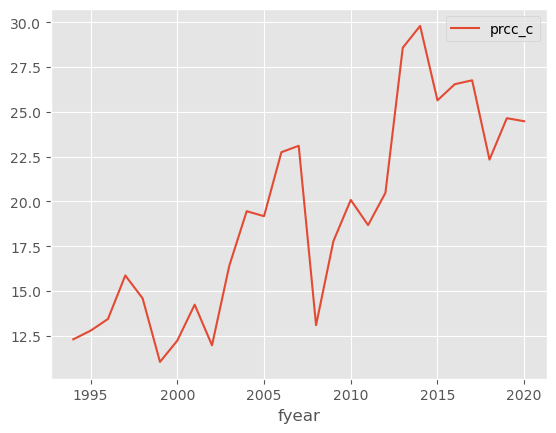

In [16]:
mean_stock_price = df_focal_public_firms.groupby('fyear')[['prcc_c']].mean()
mean_stock_price.plot.line()

#### 5. Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?

In [17]:
'''
Solution generated by ChatGPT

props:
how do we find out 'Which firm was affected the most by the 2008 Financial Crisis, 
as measured by the percentage drop in stock price from 2007 to 2008?' using python and pandas

Original generated solution:
```
# Assuming you have a dataset called 'stock_data.csv' and it has columns 'Firm', 'Date', and 'Stock_Price'
df = pd.read_csv('stock_data.csv')

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Filter the data for 2007 and 2008
df_2007 = df[df['Date'].dt.year == 2007]
df_2008 = df[df['Date'].dt.year == 2008]

# Group by firm and get the average stock price for each year (assuming you're interested in average price)
avg_price_2007 = df_2007.groupby('Firm')['Stock_Price'].mean()
avg_price_2008 = df_2008.groupby('Firm')['Stock_Price'].mean()

# Compute the percentage drop
percentage_drop = ((avg_price_2008 - avg_price_2007) / avg_price_2007) * 100

# Find the firm with the maximum percentage drop
most_affected = percentage_drop.idxmin()
max_drop = percentage_drop.min()

print(f"The firm most affected by the 2008 Financial Crisis is {most_affected} with a drop of {max_drop:.2f}%.")
```

Changes made:
- changed the column names to match the dataset
- wraped in UDF for reusability
'''
def find_most_affected_firm_during_period(start_year, end_year):
    df_start = filter_by_col_value(df_focal_public_firms, 'fyear', start_year)
    df_end = filter_by_col_value(df_focal_public_firms, 'fyear', end_year)

    avg_price_start = df_start.groupby('gvkey')['prcc_c'].mean()
    avg_price_end = df_end.groupby('gvkey')['prcc_c'].mean()

    percentage_drop = ((avg_price_end - avg_price_start) / avg_price_start) * 100

    most_affected_gvkey = percentage_drop.idxmin()
    most_affected_conm = filter_by_col_value(df_end, 'gvkey', most_affected_gvkey)['conm'].values[0]
    max_drop = abs(percentage_drop.min())

    print(f"The firm most affected between {start_year} and {end_year} is {most_affected_conm} (gvkey: {most_affected_gvkey}) with a drop of {max_drop}%.")

find_most_affected_firm_during_period(2007, 2008)


The firm most affected between 2007 and 2008 is CENTRAL ENERGY PARTNERS LP (gvkey: 161977) with a drop of 92.70588235294117%.


#### 6. Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as `ni/asset`.

<Axes: xlabel='fyear'>

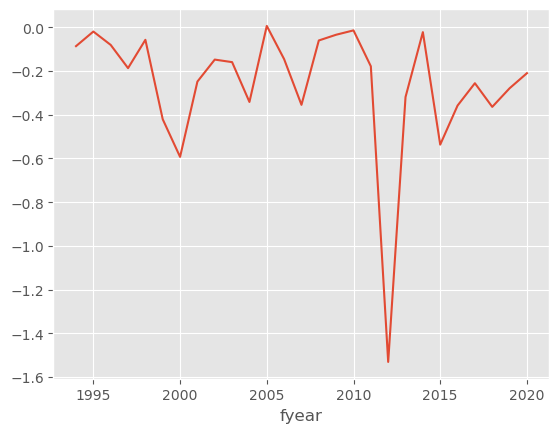

In [18]:
df_usa = filter_by_col_value(df_focal_public_firms, 'location', 'USA')
df_usa['roa'] = df_usa['ni'] / df_usa['asset']
avg_return_on_assets = df_usa.groupby('fyear')['roa'].mean()
avg_return_on_assets.plot.line()


## Part 2. Text Analysis on the Industry Sector

### C. Text Cleaning

In [19]:
# Copied from 'nlp part 2 text cleaning and keyword extraction-ba1.ipynb'
translator = str.maketrans('', '', string.punctuation)
sw = stopwords.words('english')

def clean_text(text):
    #1.	Convert all words to lowercase.
    clean_text = text.lower()

    #2.	Remove punctuations.
    clean_text = clean_text.translate(translator)

    #3.	Remove stop words based on the list of English stop words in NLTK.
    clean_words = [w for w in clean_text.split() if w not in sw]
    
    return ' '.join(clean_words)

df_2020_10K_item1['item_1_clean'] = df_2020_10K_item1['item_1_text'].apply(clean_text)

df_2020_10K_item1.head()


,cik,year,name,item_1_text,gvkey,item_1_clean
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119,fixed expenses previosuly documented 8k 235000...
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788,general hurco companies inc international indu...
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584,engaged business developing marketing products...
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...
4,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...


### D. Keyword Analysis

#### 1. Create a new DataFrame with only firms in your selected industry sectors. Merge the 10-K data with the previous "public_firm.csv" data using an inner join.

In [20]:
df_filtered=pd.merge(
    df_2020_10K_item1,
    df_focal_public_firms,
    left_on=['gvkey', 'year'],
    right_on=['gvkey', 'fyear'],
    how='inner'
)

df_filtered.head(10)


,cik,year,name,item_1_text,gvkey,item_1_clean,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
0,1007019,2020,COFFEE HOLDING CO INC,General Overview Products and Operations. We a...,160742,general overview products operations integrate...,2020,USA,COFFEE HOLDING CO INC,2005/05/03,5140,3.84,2.875,-0.094,38.480,74.336,-0.002443
1,1665918,2020,US Foods Holding Corp.,US Foods Holding Corp. and its consolidated su...,18312,us foods holding corp consolidated subsidiarie...,2020,USA,US FOODS HOLDING CORP,2016/05/26,5140,33.31,828.000,-226.000,12423.000,22885.000,-0.018192
2,1176334,2020,MARTIN MIDSTREAM PARTNERS L.P.,"References in this annual report to we, our...",150201,references annual report us like terms used hi...,2020,USA,MARTIN MIDSTREAM PARTNERS LP,2002/11/01,5172,1.43,4.958,-6.771,579.638,672.142,-0.011681
3,1180262,2020,HERBALIFE NUTRITION LTD.,"GENERAL Founded in 1980, we are a global nutri...",14269,general founded 1980 global nutrition company ...,2020,USA,HERBALIFE NUTRITION LTD,NaN,5122,48.05,1045.400,372.600,3076.100,5541.800,0.121127
4,1552275,2020,Sunoco LP,"General As used in this document, the terms P...",12892,general used document terms partnership sun us...,2020,USA,SUNOCO LP,NaN,5172,28.78,97.000,212.000,5267.000,10710.000,0.040251
5,71829,2020,NEWPARK RESOURCES INC,"General Newpark Resources, Inc. was organized ...",7882,general newpark resources inc organized 1932 n...,2020,USA,NEWPARK RESOURCES,NaN,5160,1.92,24.197,-80.696,709.192,492.625,-0.113786
6,1517175,2020,"Chefs' Warehouse, Inc.",We are a premier distributor of specialty food...,186960,premier distributor specialty food centerofthe...,2020,USA,CHEFS' WAREHOUSE INC,2011/07/28,5140,25.69,193.281,-82.903,974.325,1111.631,-0.085088
7,1494319,2020,Univar Solutions Inc.,General We are a leading global chemical and i...,21515,general leading global chemical ingredient dis...,2020,USA,UNIVAR SOLUTIONS INC,2015/06/18,5160,19.01,386.600,52.900,6355.000,8265.000,0.008324
8,1538849,2020,CrossAmerica Partners LP,Overview We were formed as a Delaware limited ...,15212,overview formed delaware limited partnership 2...,2020,USA,CROSSAMERICA PARTNERS LP,2012/10/25,5172,17.17,0.513,107.456,1014.342,1790.894,0.105937
9,877422,2020,SpartanNash Co,Overview SpartanNash Company (together with it...,28762,overview spartannash company together subsidia...,2020,USA,SPARTANNASH CO,NaN,5141,17.41,19.903,75.914,2277.391,9348.485,0.033334


#### 2. Generate the top 10 keywords for each firm based on two different methods: word counts and TF-IDF score.

##### Method 1: word counts

In [44]:
# Copied from 'nlp part 2 text cleaning and keyword extraction-ba1.ipynb'
def get_top_keywords(text):
    c = Counter(text.split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join(x[0] for x in c.most_common(10))

df_filtered['top_10_keywords_count'] = df_filtered['item_1_clean'].apply(get_top_keywords)
print(df_filtered['top_10_keywords_count'].head(10))


0    coffee green specialty market ● united states ...
1    us food president customers products mr vice s...
2    us sulfur products services transportation man...
3    products members sales marketing us product nu...
4    fuel motor retail distribution operations stat...
5    fluids drilling services customers systems seg...
6    products customers food sales product customer...
7    products chemical chemicals services ingredien...
8    fuel motor retail sites • wholesale 2019 distr...
9    company products retail distribution stores fo...
Name: top_10_keywords_count, dtype: object

##### Method 2: TF-IDF score

In [22]:
# Copied from 'nlp part 2 text cleaning and keyword extraction-ba1.ipynb'
def get_keywords_tfidf(document_list):
    '''
    Input: A list of documents (text)
    Output: The corresponding top 10 keywords for each document based on tf-idf values
    '''

    # Step 1: Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Step 2: Calculate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(document_list)

    # Step 3: Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Step 4: Extract top 10 keywords for each text
    top_keywords = []
    for i in range(len(document_list)):

        if i %100 == 0:
            print(f'Processing the {i}/{len(document_list)} document.')
        
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))
    
    return top_keywords

df_filtered['top_10_keywords_tfidf'] = get_keywords_tfidf(df_filtered['item_1_clean'].tolist())
df_filtered['top_10_keywords_tfidf'].head(10)


Processing the 0/53 document.


0    coffee green coffees beans espresso specialty ...
1    vice mr president us foodservice served food c...
2    sulfur martin marine terminals resource transp...
3    members products nutrition herbalife sales mem...
4    fuel motor eto retail dealers gasoline sunoco ...
5    fluids drilling mats ep composite mat segment ...
6    culinary products customers food centerofthepl...
7    chemical chemicals producers ingredients produ...
8    motor fuel circle sites dms retail lease whole...
9    company deca military commissaries retail stor...
Name: top_10_keywords_tfidf, dtype: object

#### 3. Create two wordclouds to visualize the keywords across all firms in the selected sector: one based on the word count of keywords and another based on the TF-IDF score.

In [23]:
# define UDF to create wordcloud
def create_wordcloud(text, title = None):
    wordcloud = WordCloud(width=1000, height=618, background_color='white').generate(text) # note that text is a string, not a list

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)

    plt.show()
    

##### 1. word count

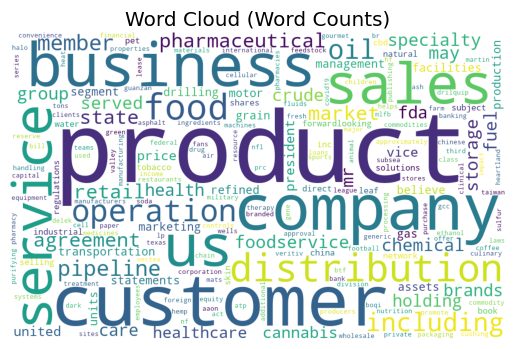

In [24]:
all_words_c = ' '.join(df_filtered['top_10_keywords_count'])
create_wordcloud(all_words_c, 'Word Cloud (Word Counts)')


##### 2. TF-IDF

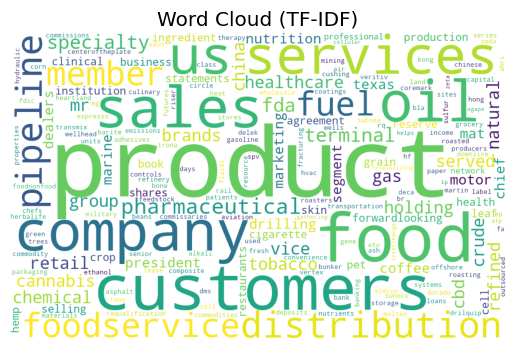

In [25]:
all_words_t = ' '.join(df_filtered['top_10_keywords_tfidf'])
create_wordcloud(all_words_t, 'Word Cloud (TF-IDF)')


### E. Word Embedding

#### 1. Train a word2vec model with the full 10-K sample (Please use the cleaned text for training)

In [26]:
# define UDF to load word2vec model or train it if it doesn't exist
def get_model(sent):
    path = './data/word2vec.model'
    # load the model if it exists to save time
    if os.path.exists(path):
        return Word2Vec.load(path)
    # otherwise, train the model and save it
    model = Word2Vec(sent, min_count=1, vector_size=50, workers=3, window=3, sg = 1)
    model.save(path)
    return model

sent = [row.split() for row in df_2020_10K_item1['item_1_clean']]

model = get_model(sent)


#### 2. Inspect the wordclouds in D.3 and choose three representative keywords. Utilize the trained model to find the most relevant five words for each keywords.

In [27]:
words_choosen = ['product', 'food', 'oil']

# Product
model.wv.most_similar(words_choosen[0], topn=5)


[('sugardown®', 0.8190038204193115),
 ('twirla', 0.8148636221885681),
 ('contrapest', 0.8115096092224121),
 ('apcannabinoids', 0.8047302961349487),
 ('codit', 0.8034622669219971)]

In [28]:
# Food
model.wv.most_similar(words_choosen[1], topn=5)


[('meat', 0.8364577889442444),
 ('beverage', 0.8194589018821716),
 ('perishable', 0.8126021027565002),
 ('poultry', 0.7997170090675354),
 ('foods', 0.797221302986145)]

In [29]:
# Oil
model.wv.most_similar(words_choosen[2], topn=5)


[('gas', 0.9528785943984985),
 ('crude', 0.9351126551628113),
 ('natural', 0.8964820504188538),
 ('condensate', 0.8721504211425781),
 ('ngls', 0.8620993494987488)]

## Part 3. Comprehensive Analysis of One Sample Firm

### F. Firm Analysis and Strategy Suggestion

**Write up for analysis and recommendations see project report.**

#### 1. Convert the keywords into word embeddings with the word2vec model create the firm-level embeddings then find the focal firm’s competing firms

In [30]:
d = DocumentSimilarity(
    model = model,
    gvkeys = df_filtered['gvkey'],
    conm = df_filtered['conm'],
    keywordslist = df_filtered['top_10_keywords_tfidf']
)

# Our focal firm is SYSCO CORP (gvkey: 10247)
focal_firm_gvkey = 10247

competitors = d.most_similar(firm = focal_firm_gvkey, topn = 5)

competitors


[(63927, 'UNITED NATURAL FOODS INC', 0.9493776),
 (28762, 'SPARTANNASH CO', 0.9471067),
 (162876, 'CORE MARK HOLDING CO INC', 0.9441933),
 (162335, 'PRESTIGE CONSUMER HEALTHCARE', 0.9324935),
 (186960, "CHEFS' WAREHOUSE INC", 0.9298404)]

#### 2. Compare the revenue, market share, and ROA of the focal firm to its competitors and provide suggestions accordingly.

In [31]:
comparison_gvkeys = [focal_firm_gvkey] + [x[0] for x in competitors]

df_comparison = df_filtered[df_filtered['gvkey'].isin(comparison_gvkeys)][['gvkey', 'conm', 'sale', 'roa']]

df_comparison['market_share'] = df_comparison['sale'] / df_comparison['sale'].sum()

df_comparison


,gvkey,conm,sale,roa,market_share
6,186960,CHEFS' WAREHOUSE INC,1111.631,-0.085088,0.010645
9,28762,SPARTANNASH CO,9348.485,0.033334,0.089521
17,162876,CORE MARK HOLDING CO INC,13617.100,0.032332,0.130397
31,162335,PRESTIGE CONSUMER HEALTHCARE,943.365,0.048022,0.009034
44,10247,SYSCO CORP,52893.310,0.009522,0.506504
45,63927,UNITED NATURAL FOODS INC,26514.267,-0.036133,0.253900


In [32]:
labels = [x.split()[0] for x in df_comparison['conm'].tolist()]

def plot_bar(data, title):
    plt.bar(range(len(data)), data, tick_label=labels)
    plt.show()

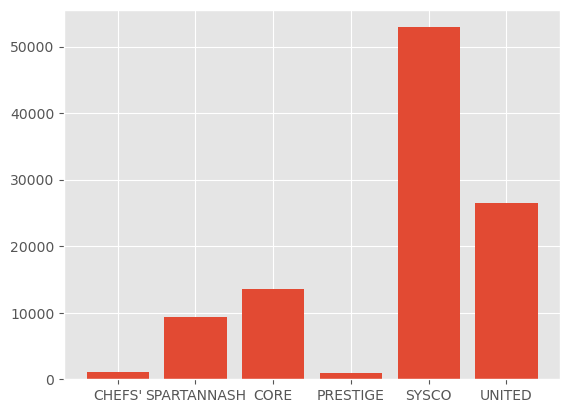

In [33]:
sale_data = df_comparison['sale'].tolist()
plot_bar(sale_data, 'Revenue')

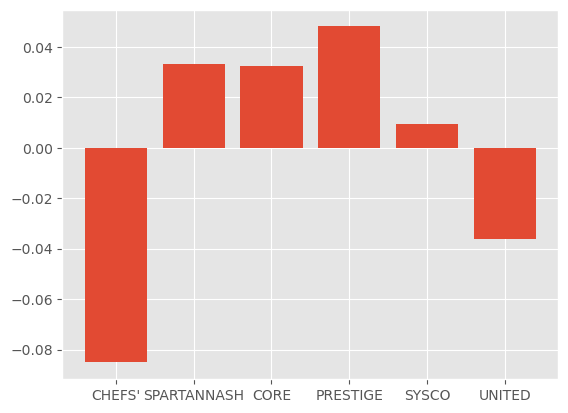

In [34]:
roa_data = df_comparison['roa'].tolist()
plot_bar(roa_data, 'ROA')

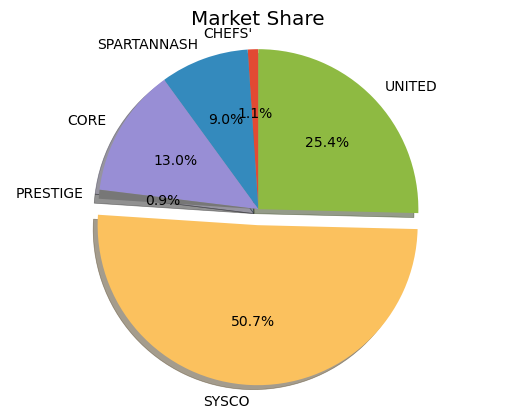

In [35]:
'''
https://zhuanlan.zhihu.com/p/26812779
Learned about matplotlib pie chart from this blog
'''

data_market_share = df_comparison['market_share'].tolist()
explode = (0, 0, 0, 0, 0.1, 0)
fig1, ax1 = plt.subplots()
ax1.pie(data_market_share, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Market Share')
plt.show()



#### 3.	Perform an analysis of the historical stock prices, ROA, revenue, and assets of the chosen company. Investigate potential correlations and address noteworthy decreases and increases.

In [36]:
cols = ['fyear', 'prcc_c', 'roa', 'sale', 'asset']
df_focal_firm_historical = filter_by_col_value(df_focal_public_firms, 'gvkey', focal_firm_gvkey)[cols]
df_focal_firm_historical


,fyear,prcc_c,roa,sale,asset
37524,1995,32.5000,0.081373,12118.047,3094.691
37525,1996,32.6250,0.083270,13395.130,3325.405
37526,1997,45.5620,0.088032,14454.589,3436.611
37527,1998,27.4375,0.078506,15327.536,3780.189
37528,1999,39.5625,0.088433,17422.815,4096.582
37529,2000,30.0000,0.092562,19303.268,4813.955
37530,2001,26.2200,0.109154,21784.497,5468.521
37531,2002,29.7900,0.113492,23350.504,5989.753
37532,2003,37.2300,0.112201,26140.337,6936.521
37533,2004,38.1700,0.115604,29335.403,7847.632


In [37]:
# Correlation matrix among variables
df_focal_firm_historical[cols].corr()


,fyear,prcc_c,roa,sale,asset
fyear,1.000000,0.634846,-0.466523,0.991473,0.975166
prcc_c,0.634846,1.000000,-0.566861,0.651036,0.712240
roa,-0.466523,-0.566861,1.000000,-0.418462,-0.608430
sale,0.991473,0.651036,-0.418462,1.000000,0.963589
asset,0.975166,0.712240,-0.608430,0.963589,1.000000


In [38]:
def create_line_chart_over_fyear(col, title, y_label):
    plt.plot(df_focal_firm_historical['fyear'].to_list(), df_focal_firm_historical[col].to_list())
    plt.title(title)
    plt.xlabel('Firm Year')
    plt.ylabel(y_label)
    plt.show()
    

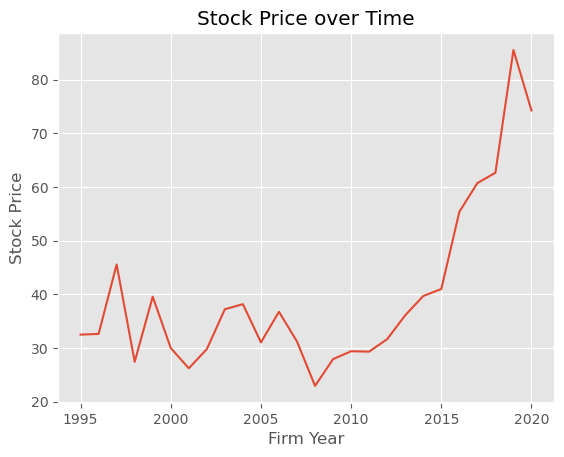

In [39]:
create_line_chart_over_fyear('prcc_c', 'Stock Price over Time', 'Stock Price')


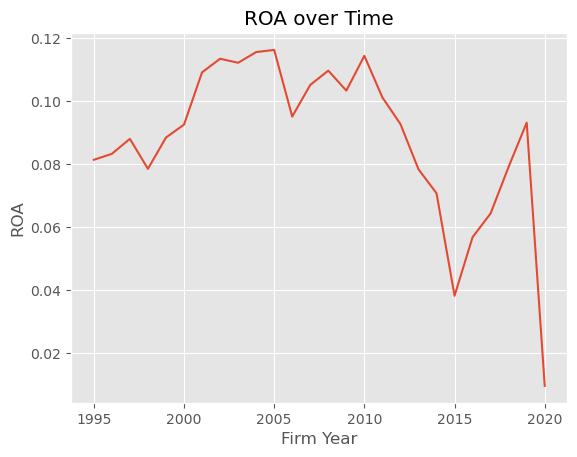

In [40]:
create_line_chart_over_fyear('roa', 'ROA over Time', 'ROA')


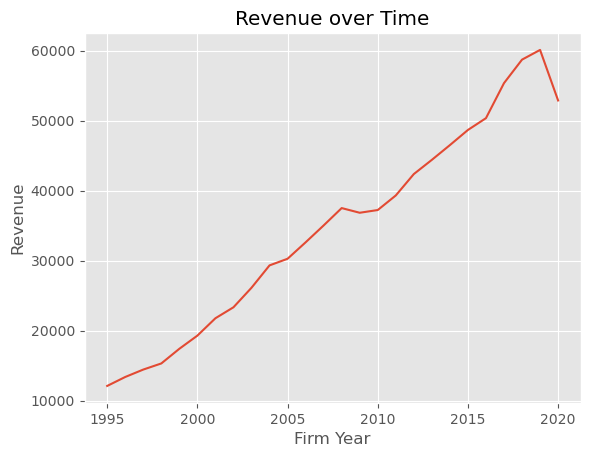

In [41]:
create_line_chart_over_fyear('sale', 'Revenue over Time', 'Revenue')


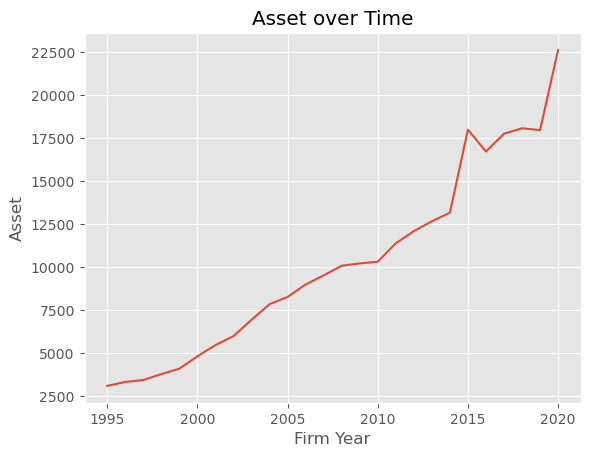

In [42]:
create_line_chart_over_fyear('asset', 'Asset over Time', 'Asset')


## That's all for this notebook! Thank you!